# Chapter 11: Training deep neural networks


Neural networks suffer from vanishing (too small) or exploding (too large) gradients.
This caused them to be abandoned.

Xavier Glorot and Yoshua Bengio showed in 2010 that this was caused by logistic activation (mean is 0.5, and gradient is close to the edges: output 0 or output 1) or the initialization used.

The outcome was to have a fan-in as close to fan-out for hidden layers, and the initialization is done in a crafty way to account for differences in fan-in and fan-out called Xavier initialization now. $\sigma^2 = 1/{fan}$, fan is the average of fan-in and fan-out.


Another approach is to use Rectified Linear Units (ReLU) with another kind of initialization called He Initialization. $\sigma^2 = 2/{fan}_{in}$

A third approach is Scaled Exponential Linear Units (SELU) with a third initialization mechanism called LeCunn Initialization. $\sigma^2 = 1/{fan}_{in}$

This can be modified in Keras by doing kernel_initializer="he_uniform" or "he_normal" etc.

The 2010 paper showed that just because biological neurons use logistic activation, we don't have to. And in fact, using them causes all sorts of mathematical problems. ReLU activation functions work well in practice, but suffer from a problem where once they start outputting 0, they stay there. As a result, a leaky ReLU works better when it outputs a small negative value instead of 0 all the way through.

The exponential LU is an exponential function shifted down by 1, so it outputs -1 (instead of 0 at $-\inf$ and 0 at 1): ${ELU}(z) = exp(z) - 1$. Differentiable, doesn't cause vanishing or exploding gradients. Slower to compute

SELU needs sequential networks (no skip connections). Needs a specific initializer "lecun_normal", and standard scaling of inputs. When this happens, SELU will self-normalize (mean 0 and variance 1, this is desirable) when all hidden layers use SELU.


Initialization choices listed above only help at the start of the training. During training, the intermediate layers can still have poor gradients. Batch Normalization is a set of extra layers added that seek to estimate the mean and variance of their inputs at their layer (during training), and modify output scaling and output shifting as errors are calculated. After training, the layer modifies its inputs by using the training means and variances, and also modifies the output to scale and shift it to ensure that the behavior at that layer is good.

I don't have a good sense of it though. To standard-scale the input, it must be applied before a hidden neural network layer, and to modify the output, it should be applied after the neural network layer. Not sure how this really works in practice.


This chapter was mostly talk. The exercises are where the information get solidified.



# Exercises

1. It is ok to initialize values to the same thing, though you are better off with random initialization to different values.

2. Nope, not ok to initialize values to 0. Some of the activation functions have a zero gradient (or undefined gradient) at 0. Best to initialize to nonzero values.

3. SELU is differentiable everywhere, and usually converges faster, even though it is slower to compute.
 When SELU is used in all layers, it self-normalizes to mean 0 and standard deviation of 1, which greatly helps convergence.

4. SELU: when the input can be scaled, and 

5. No idea. Probably the result doesn't converge?

6. Sparse models can be produced by:
  * Using dropout. This removes some nodes.
  * High value of regularization.
  * Ue Tensorflow's Model Optimization Toolkit (MOT) to prune connections with small magnitude.

7. Dropout might down training as we might need more iterations to converge. It does speeds up inference. MC Dropout slows down training as we have to get the boosted model iteratively. And it does slow down inference as well (inference requires training with dropout turned on and keeping the previous inferred results to average)

8. Doing that below here.






In [1]:
# Common imports

import matplotlib.cm as cm
from matplotlib.image import imread
import matplotlib as mpl
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

import numpy as np

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_samples
from sklearn.metrics import silhouette_score

from sklearn.datasets import fetch_california_housing
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras

print("TF version ", tf.__version__)
print("Keras version ", keras.__version__)

# Custom error handler for the entire notebook so stack traces are not lost
from IPython.core.ultratb import AutoFormattedTB

# initialize the formatter for making the tracebacks into strings
itb = AutoFormattedTB(mode = 'Plain', tb_offset = 1)

# Define a global with the stack trace that we can append to in the handler.
viki_stack_trace = ''

# this function will be called on exceptions in any cell
def custom_exc(shell, etype, evalue, tb, tb_offset=None):
    global viki_stack_trace

    # still show the error within the notebook, don't just swallow it
    shell.showtraceback((etype, evalue, tb), tb_offset=tb_offset)

    # grab the traceback and make it into a list of strings
    stb = itb.structured_traceback(etype, evalue, tb)
    sstb = itb.stb2text(stb)

    print (sstb) # <--- this is the variable with the traceback string
    viki_stack_trace = viki_stack_trace + sstb

# this registers a custom exception handler for the whole current notebook
get_ipython().set_custom_exc((Exception,), custom_exc)


TF version  2.3.0
Keras version  2.4.0


In [8]:
cifar = keras.datasets.cifar10.load_data()

In [2]:
(X, y), (testX, testy) = keras.datasets.cifar10.load_data()

In [6]:
X_train, X_valid = X[:40000] / 255.0, X[40000:] / 255.0
y = y.reshape(50000)
testy.reshape(10000)

y_train, y_valid = y[:40000]        , y[40000:]

print("Validation: ", X_valid.shape)
print("Training: ", X_train.shape)
print("Labels validation: ", y_valid.shape)
print("Labels training: ", y_train.shape)

print("Test: ", testX.shape)
print("Labels test: ", testy.shape)

Validation:  (10000, 32, 32, 3)
Training:  (40000, 32, 32, 3)
Labels validation:  (10000,)
Labels training:  (40000,)
Test:  (10000, 32, 32, 3)
Labels test:  (10000, 1)


In [53]:
X.shape

(50000, 32, 32, 3)

In [56]:
y.shape

(50000, 1)

In [55]:
X[2].shape

(32, 32, 3)

In [86]:
from sklearn.base import clone

def create_keras_classifier_model(n_classes=100):
    """Keras multinomial logistic regression creation model
 
    Args:
        n_classes(int): Number of classes to be classified
 
    Returns:
        Compiled keras model
 
    """
    # create model
    model = keras.models.Sequential()
    
    # The input: we get 32x32 pixels, each with 3 colors (rgb)
    model.add(keras.layers.Flatten(input_shape=[32,32,3]))
    # Then the hidden layers, fully connected (100 by default)
    for i in range(20):
        model.add(keras.layers.Dense(
            n_classes, 
            activation="elu",
            kernel_initializer=tf.keras.initializers.HeNormal()
        ))
    # Now add the output layer: 10 classes in CIFAR10, so 10 outputs.
    model.add(keras.layers.Dense(10, activation="softmax"))

    # print(model.summary())
    # Compile model
    nadam = keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

    model.compile(
        loss="sparse_categorical_crossentropy", 
        optimizer=nadam,
        metrics=["accuracy"]
    )
    return model
 
estimator = keras.wrappers.scikit_learn.KerasClassifier(
    build_fn=create_keras_classifier_model,
    n_classes=10,
    class_weight={0: 1, 1:3})

viki_stack_trace = ''

mm = create_keras_classifier_model(100)
print ("Model built: ", mm)

Model built:  <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f8fc0ee2100>


Need to create a model and test against the training data.

In [77]:
history = mm.fit(trainX, trainy, epochs=30, verbose=0)

Epoch 1/30
1563/1563 [==============================] - 84s 54ms/step - loss: 3.3307 - accuracy: 0.2220
Epoch 2/30
1563/1563 [==============================] - 85s 54ms/step - loss: 1.9199 - accuracy: 0.2920
Epoch 3/30
1563/1563 [==============================] - 84s 54ms/step - loss: 1.8658 - accuracy: 0.3137
Epoch 4/30
1563/1563 [==============================] - 84s 54ms/step - loss: 1.8350 - accuracy: 0.3299
Epoch 5/30
1563/1563 [==============================] - 84s 54ms/step - loss: 1.7982 - accuracy: 0.3459
Epoch 6/30
1563/1563 [==============================] - 84s 54ms/step - loss: 1.7787 - accuracy: 0.3539
Epoch 7/30
1563/1563 [==============================] - 84s 54ms/step - loss: 1.7599 - accuracy: 0.3602
Epoch 8/30
1563/1563 [==============================] - 84s 54ms/step - loss: 2.5332 - accuracy: 0.3436
Epoch 9/30
1563/1563 [==============================] - 84s 54ms/step - loss: 2.0148 - accuracy: 0.2232
Epoch 10/30
1563/1563 [==============================] - 84s 54m

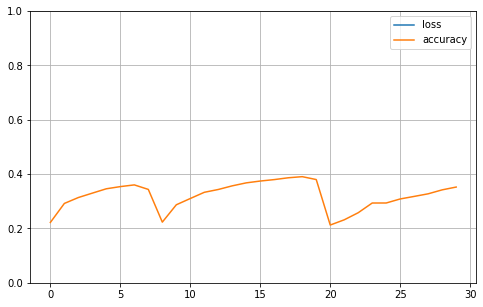

In [78]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1) # Y axis set to [0,1]
plt.show()

In [80]:
(loss, accuracy) = mm.evaluate(testX, testy)

313/313 [==============================] - 8s 25ms/step - loss: 1.7779 - accuracy: 0.3484


In [83]:
print ("Loss is %f" % loss)
print ("Accuracy is %f" % accuracy)

Loss is 1.777857
Accuracy is 0.348400


That wasn't any good. Let's try with more epochs, and a smaller learning schedule.

In [87]:
history = mm.fit(trainX, trainy, epochs=300, verbose=0)

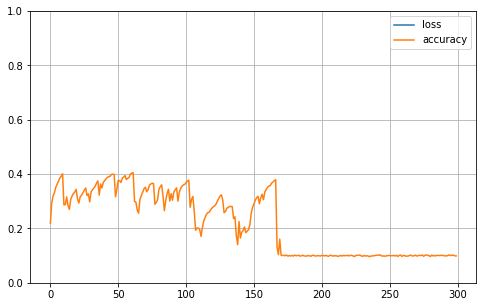

In [88]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1) # Y axis set to [0,1]
plt.show()

Wow, what happened here? This is not working out at all.

In [106]:
from sklearn.base import clone

def create_keras_classifier_model(hidden_neurons=100):
    """Keras multinomial logistic regression creation model
 
    Args:
        n_classes(int): Number of classes to be classified
 
    Returns:
        Compiled keras model
 
    """
    # create model
    model = keras.models.Sequential()
    
    # The input: we get 32x32 pixels, each with 3 colors (rgb)
    model.add(keras.layers.Flatten(input_shape=[32,32,3]))
    # Then the hidden layers, fully connected (100 by default)
    for i in range(20):
        model.add(keras.layers.Dense(
            hidden_neurons, 
            activation="elu",
            kernel_initializer=tf.keras.initializers.HeNormal()
        ))
    # Now add the output layer: 10 classes in CIFAR10, so 10 outputs.
    model.add(keras.layers.Dense(10, activation="softmax"))

    # print(model.summary())
    # Compile model
    nadam = keras.optimizers.Nadam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

    model.compile(
        loss="sparse_categorical_crossentropy", 
        optimizer=nadam,
        metrics=["accuracy"]
    )
    return model

# Clear the errors, in case we observe them in the long run.
viki_stack_trace = ''

# Build a model with 20 layers of 100 hidden neurons each.
mm = create_keras_classifier_model(100)
print ("Model built: ", mm)

Model built:  <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f8fc25c54f0>


Let's scale the attributes, and reshape the observations, and let's set aside some data for validation during training.

Split training and validation, and flattening out the labels.

In [3]:
X_train, X_valid = X[:40000] / 255.0, X[40000:] / 255.0
y = y.reshape(50000)
testy.reshape(10000)

y_train, y_valid = y[:40000]        , y[40000:]

print("Validation: ", X_valid.shape)
print("Training: ", X_train.shape)
print("Labels validation: ", y_valid.shape)
print("Labels training: ", y_train.shape)

print("Test: ", testX.shape)
print("Labels test: ", testy.shape)

Validation:  (10000, 32, 32, 3)
Training:  (40000, 32, 32, 3)
Labels validation:  (10000,)
Labels training:  (40000,)
Test:  (10000, 32, 32, 3)
Labels test:  (10000, 1)


Let's validate that the distribution of classes in the test, validation and training dataset is fine


(array([1014., 1014.,  952., 1016.,  997., 1025.,  980.,  977., 1003.,
        1022.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

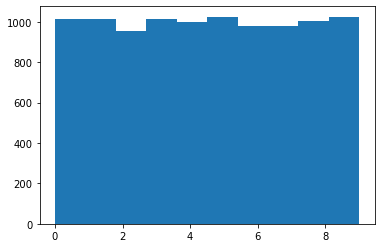

In [4]:
plt.hist(y_valid)

(array([3986., 3986., 4048., 3984., 4003., 3975., 4020., 4023., 3997.,
        3978.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

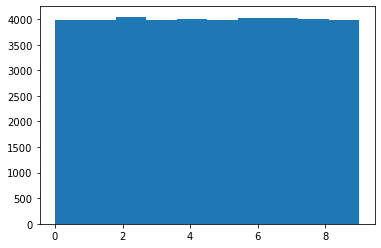

In [5]:
plt.hist(y_train)

(array([1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
        1000.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

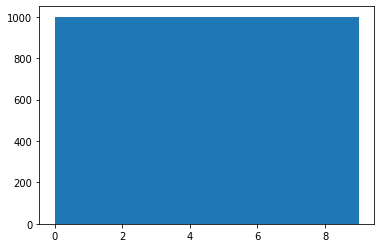

In [110]:
plt.hist(testy)

Ok, those look ok, so we don't have a huge skew in the classes in the validation, test or training data.

In [111]:
history = mm.fit(X_train, y_train, epochs=300, verbose=1,
                 validation_data=(X_valid, y_valid))

Epoch 1/300
313/313 [==============================] - 46s 148ms/step - loss: 1.9601 - accuracy: 0.2870 - val_loss: 1.8911 - val_accuracy: 0.3068
Epoch 2/300
313/313 [==============================] - 45s 143ms/step - loss: 1.8609 - accuracy: 0.3322 - val_loss: 2.0836 - val_accuracy: 0.2698
Epoch 3/300
313/313 [==============================] - 45s 143ms/step - loss: 1.7955 - accuracy: 0.3543 - val_loss: 1.9362 - val_accuracy: 0.3010
Epoch 4/300
313/313 [==============================] - 45s 142ms/step - loss: 1.7331 - accuracy: 0.3726 - val_loss: 1.7834 - val_accuracy: 0.3540
Epoch 5/300
313/313 [==============================] - 45s 143ms/step - loss: 1.6960 - accuracy: 0.3851 - val_loss: 1.7824 - val_accuracy: 0.3622
Epoch 6/300
313/313 [==============================] - 45s 143ms/step - loss: 1.6431 - accuracy: 0.4050 - val_loss: 1.7908 - val_accuracy: 0.3632
Epoch 7/300
313/313 [==============================] - 45s 142ms/step - loss: 1.6057 - accuracy: 0.4231 - val_loss: 1.7062 -

Epoch 57/300
313/313 [==============================] - 45s 142ms/step - loss: 0.3793 - accuracy: 0.8649 - val_loss: 3.1451 - val_accuracy: 0.4012
Epoch 58/300
313/313 [==============================] - 45s 142ms/step - loss: 0.3745 - accuracy: 0.8634 - val_loss: 3.3669 - val_accuracy: 0.3945
Epoch 59/300
313/313 [==============================] - 45s 142ms/step - loss: 0.3694 - accuracy: 0.8716 - val_loss: 3.3350 - val_accuracy: 0.3907
Epoch 60/300
313/313 [==============================] - 45s 143ms/step - loss: 0.3530 - accuracy: 0.8758 - val_loss: 3.5949 - val_accuracy: 0.4024
Epoch 61/300
313/313 [==============================] - 44s 142ms/step - loss: 0.3395 - accuracy: 0.8810 - val_loss: 3.8245 - val_accuracy: 0.3973
Epoch 62/300
313/313 [==============================] - 45s 142ms/step - loss: 0.3637 - accuracy: 0.8692 - val_loss: 3.6379 - val_accuracy: 0.3974
Epoch 63/300
313/313 [==============================] - 45s 143ms/step - loss: 0.3434 - accuracy: 0.8771 - val_loss: 3

KeyboardInterrupt: 

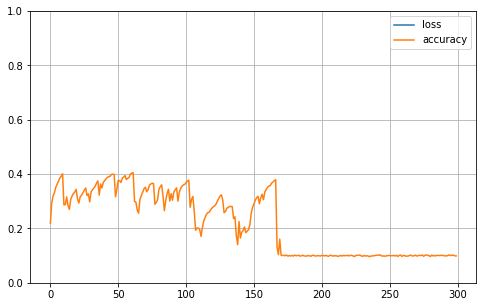

In [113]:
# I should run 100 epochs, and then print this graph. That allows me to check things are going well. If they
# are, then we scan run 200 more epochs if needed.

import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1) # Y axis set to [0,1]
plt.show()

That is severely over-fitting. Training data accuracy is 92% but validation accuracy is about 40%. Stopping this now.

Let's try increasing the batch size. By default, model.fit() uses a [batch size of 32](https://www.tensorflow.org/api_docs/python/tf/keras/Model), and we can try increasing this. Also looks like the learning rate is too low.

Also, let's use L2 regularization to avoid overfitting

In [114]:
from sklearn.base import clone

def create_keras_classifier_model(n_classes=100):
    """Keras multinomial logistic regression creation model
 
    Args:
        n_classes(int): Number of classes to be classified
 
    Returns:
        Compiled keras model
 
    """
    # create model
    model = keras.models.Sequential()
    
    # The input: we get 32x32 pixels, each with 3 colors (rgb)
    model.add(keras.layers.Flatten(input_shape=[32,32,3]))
    # Then the hidden layers, fully connected (100 by default)
    for i in range(20):
        model.add(keras.layers.Dense(
            n_classes, 
            activation="elu",
            kernel_initializer=tf.keras.initializers.HeNormal(),
            kernel_regularizer=tf.keras.regularizers.l2(0.01),
        ))
    # Now add the output layer: 10 classes in CIFAR10, so 10 outputs.
    model.add(keras.layers.Dense(10, activation="softmax"))

    # print(model.summary())
    # Compile model
    nadam = keras.optimizers.Nadam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

    model.compile(
        loss="sparse_categorical_crossentropy", 
        optimizer=nadam,
        metrics=["accuracy"]
    )
    return model

# Clear the errors, in case we observe them in the long run.
viki_stack_trace = ''

mm2 = create_keras_classifier_model(100)
print ("Model built: ", mm)

Model built:  <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f8fc25c54f0>


In [115]:
history2_bigbatch = mm2.fit(X_train, y_train, epochs=100, verbose=1,
                 batch_size=42,
                 validation_data=(X_valid, y_valid))

Epoch 1/100
239/239 [==============================] - 47s 195ms/step - loss: 41.3250 - accuracy: 0.2097 - val_loss: 40.1171 - val_accuracy: 0.2076
Epoch 2/100
239/239 [==============================] - 43s 179ms/step - loss: 38.6378 - accuracy: 0.2952 - val_loss: 37.5655 - val_accuracy: 0.2166
Epoch 3/100
239/239 [==============================] - 46s 192ms/step - loss: 36.0718 - accuracy: 0.3278 - val_loss: 35.4213 - val_accuracy: 0.1645
Epoch 4/100
239/239 [==============================] - 45s 189ms/step - loss: 33.6465 - accuracy: 0.3514 - val_loss: 32.7742 - val_accuracy: 0.2799
Epoch 5/100
239/239 [==============================] - 43s 178ms/step - loss: 31.4061 - accuracy: 0.3657 - val_loss: 30.8720 - val_accuracy: 0.2037
Epoch 6/100
239/239 [==============================] - 43s 178ms/step - loss: 29.3501 - accuracy: 0.3825 - val_loss: 28.5429 - val_accuracy: 0.3088
Epoch 7/100
239/239 [==============================] - 43s 179ms/step - loss: 27.4554 - accuracy: 0.3967 - val_l

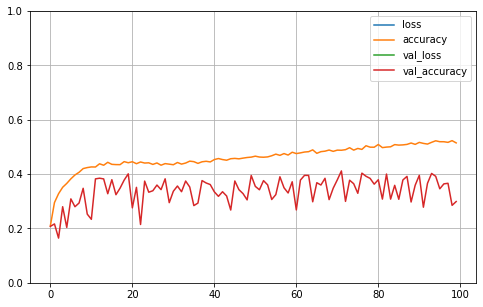

In [116]:
import pandas as pd

pd.DataFrame(history2_bigbatch.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1) # Y axis set to [0,1]
plt.show()

Let's train for 200 more epochs, though it isn't goingo to improve.

In [ ]:
history2_bigbatch = mm2.fit(X_train, y_train, epochs=200, verbose=0,
                 batch_size=32,
                 validation_data=(X_valid, y_valid))

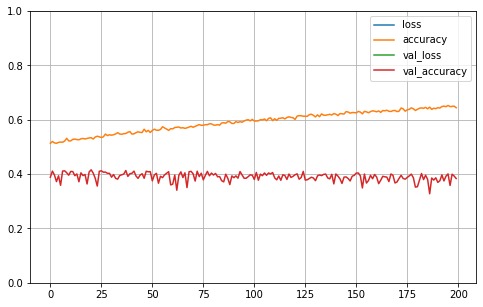

In [118]:
import pandas as pd

pd.DataFrame(history2_bigbatch.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1) # Y axis set to [0,1]
plt.show()

This is a mess. No real convergence, and the model overfits the training data, even with regularization. Maybe the point is that this doesn't work so well? Let's continue with the rest of the exercises and revisit this in the end if nothing converges.

In [ ]:
from sklearn.base import clone

def create_keras_classifier_model(n_classes=100):
    """Keras multinomial logistic regression creation model
 
    Args:
        n_classes(int): Number of classes to be classified
 
    Returns:
        Compiled keras model
 
    """
    # create model
    model = keras.models.Sequential()
    
    # The input: we get 32x32 pixels, each with 3 colors (rgb)
    model.add(keras.layers.Flatten(input_shape=[32,32,3]))
    # Then the hidden layers, fully connected (100 by default)
    for i in range(20):
        model.add(keras.layers.Dense(
            n_classes, 
            activation="elu",
            kernel_initializer=tf.keras.initializers.HeNormal(),
            kernel_regularizer=tf.keras.regularizers.l2(0.01),
        ))
        model.add(keras.layers.BatchNormalization())
    # Now add the output layer: 10 classes in CIFAR10, so 10 outputs.
    model.add(keras.layers.Dense(10, activation="softmax"))

    # print(model.summary())
    # Compile model
    nadam = keras.optimizers.Nadam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

    model.compile(
        loss="sparse_categorical_crossentropy", 
        optimizer=nadam,
        metrics=["accuracy"]
    )
    return model

# Clear the errors, in case we observe them in the long run.
viki_stack_trace = ''

# Got to remember them. mm_bn is the model with Batch normalization
mm_bn = create_keras_classifier_model(100)
print ("Model built: ", mm_bn)

history_bn = mm_bn.fit(X_train, y_train, epochs=100, verbose=0,
                 batch_size=32,
                 validation_data=(X_valid, y_valid))

Model built:  <tensorflow.python.keras.engine.sequential.Sequential object at 0x7fb8d412f310>


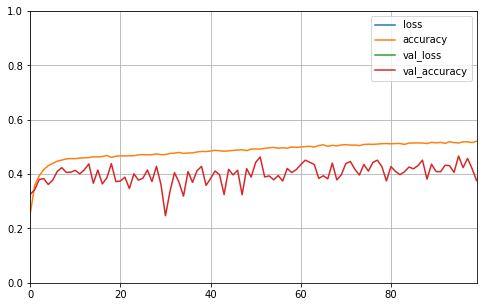

In [11]:
import pandas as pd

pd.DataFrame(history_bn.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1) # Y axis set to [0,1]
plt.show()

Build a model with Batch normalization before the layers, because that is supposed to be better.

In [ ]:
from sklearn.base import clone

def create_keras_classifier_model(n_classes=100):
    """Keras multinomial logistic regression creation model
 
    Args:
        n_classes(int): Number of classes to be classified
 
    Returns:
        Compiled keras model
 
    """
    # create model
    model = keras.models.Sequential()
    
    # The input: we get 32x32 pixels, each with 3 colors (rgb)
    model.add(keras.layers.Flatten(input_shape=[32,32,3]))
    # Batch normalization after the input output.
    model.add(keras.layers.BatchNormalization())

        
    # Then the hidden layers, fully connected (100 by default)
    for i in range(20):
        model.add(keras.layers.Dense(
            n_classes, 
            kernel_initializer=tf.keras.initializers.HeNormal(),
        ))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Activation("elu"))

    # Now add the output layer: 10 classes in CIFAR10, so 10 outputs.
    model.add(keras.layers.Dense(10, activation="softmax"))

    # print(model.summary())
    # Compile model
    nadam = keras.optimizers.Nadam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

    model.compile(
        loss="sparse_categorical_crossentropy", 
        optimizer=nadam,
        metrics=["accuracy"]
    )
    return model

# Clear the errors, in case we observe them in the long run.
viki_stack_trace = ''

# Got to remember them. mm_bn is the model with Batch normalization
mm_bn2 = create_keras_classifier_model(100)
print ("Model built: ", mm_bn2)

history_bn2 = mm_bn2.fit(X_train, y_train, epochs=100, verbose=0,
                 batch_size=32,
                 validation_data=(X_valid, y_valid))

Model built:  <tensorflow.python.keras.engine.sequential.Sequential object at 0x7fb8a867b280>


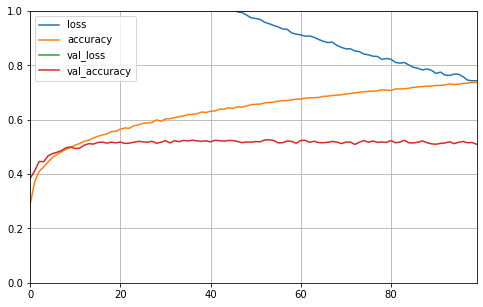

In [15]:
import pandas as pd

pd.DataFrame(history_bn2.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1) # Y axis set to [0,1]
plt.show()

Using selu and seeing if it self normalizes.

In [17]:
# Learning reshape.

X_few = X_train[:2]
print(X_few.shape)

# Flatten out each row, using C ordering where the right-most index (lowest index) is the one to increase the
# first, then the next one. The alternative is 'F'ortran ordering, where the left-most index (highest index)
# increases first. Since our observations are X[0][:], X[1], [:], and so on, we want C ordering. This is also
# the default, but forcing it to ensure I understand this in the future.
X_reshaped = X_few.reshape((2,3072), order='C')
print(X_reshaped.shape)

print (X_few[1][0][3][:])
print (X_reshaped[1][9:18])

(2, 32, 32, 3)
(2, 3072)
[0.4        0.39607843 0.38823529]
[0.4        0.39607843 0.38823529 0.49019608 0.51372549 0.54509804
 0.60784314 0.65098039 0.70588235]


In [18]:
print(X_train.shape)
print(X_valid.shape)
print(testX.shape)

(40000, 32, 32, 3)
(10000, 32, 32, 3)
(10000, 32, 32, 3)


In [ ]:
from sklearn.base import clone

def create_keras_classifier_model(n_classes=100):
    """Keras multinomial logistic regression creation model
 
    Args:
        n_classes(int): Number of classes to be classified
 
    Returns:
        Compiled keras model
 
    """
    # create model
    model = keras.models.Sequential()
    
    # The input: we get 32x32 pixels, each with 3 colors (rgb). StandardScalar wants the dimensions flattened,
    # so now this gets the input directly.
    model.add(keras.layers.Flatten(input_shape=[3072]))
    # Batch normalization after the input output.
    model.add(keras.layers.BatchNormalization())
        
    # Then the hidden layers, fully connected (100 by default)
    for i in range(20):
        model.add(keras.layers.Dense(
            n_classes, 
            kernel_initializer="lecun_normal",
        ))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Activation("selu"))

    # Now add the output layer: 10 classes in CIFAR10, so 10 outputs.
    model.add(keras.layers.Dense(10, activation="softmax"))

    # print(model.summary())
    # Compile model
    nadam = keras.optimizers.Nadam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

    model.compile(
        loss="sparse_categorical_crossentropy", 
        optimizer=nadam,
        metrics=["accuracy"]
    )
    return model

# Clear the errors, in case we observe them in the long run.
viki_stack_trace = ''

# Got to remember them. mm_bn is the model with Batch normalization
mm_selu = create_keras_classifier_model(100)
print ("Model built: ", mm_selu)

# Now we must standard scale the data.
scaler = StandardScaler()
X_train_reshape = X_train.reshape(40000, 3072)
X_valid_reshape = X_valid.reshape(10000, 3072)
X_test_reshape = testX.reshape(10000, 3072)

X_train_ss = scaler.fit_transform(X_train_reshape)
# Always use the same scaler for the X_validation and X_test!
X_valid_ss = scaler.transform(X_valid_reshape)
X_test_ss = scaler.transform(X_test_reshape)

history_selu = mm_selu.fit(X_train_ss, y_train, epochs=100, verbose=0,
                 batch_size=32,
                 validation_data=(X_valid_ss, y_valid))

Model built:  <tensorflow.python.keras.engine.sequential.Sequential object at 0x7fb8a2304cd0>


In [ ]:
import pandas as pd

pd.DataFrame(history_selu.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1) # Y axis set to [0,1]
plt.show()